In [1]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import RobustScaler
from scipy.stats import boxcox_normmax, zscore
from multiprocessing import cpu_count
from lightgbm import LGBMRegressor
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import pandas as pd
import numpy as np

In [2]:
pd.options.display.max_columns = None

In [3]:
df_train = pd.read_csv('D:/Study/Python/data-set/house_prices_advanced_regression_techniques/train.csv')
df_test = pd.read_csv('D:/Study/Python/data-set/house_prices_advanced_regression_techniques/test.csv')
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [4]:
display(df_train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


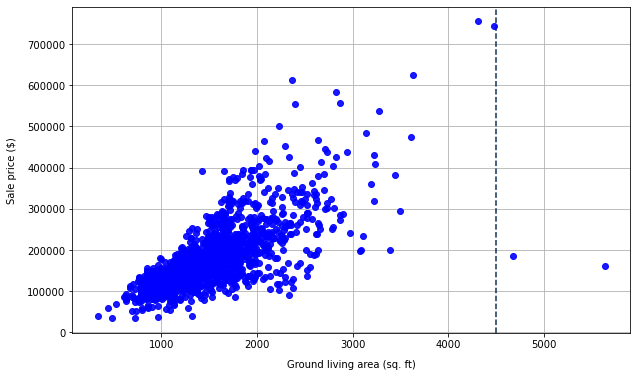

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.scatter(df_train["GrLivArea"], df_train["SalePrice"], c='b' , zorder=3, alpha=0.9)
ax.axvline(4500, c="#112d4e", ls="--", zorder=2)
ax.set_xlabel("Ground living area (sq. ft)", labelpad=10)
ax.set_ylabel("Sale price ($)", labelpad=10)
plt.show()

In [6]:
df_train = df_train[df_train["GrLivArea"] <= 4500]

In [7]:
df_train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
df_test.drop(['Id'], axis=1, inplace=True)

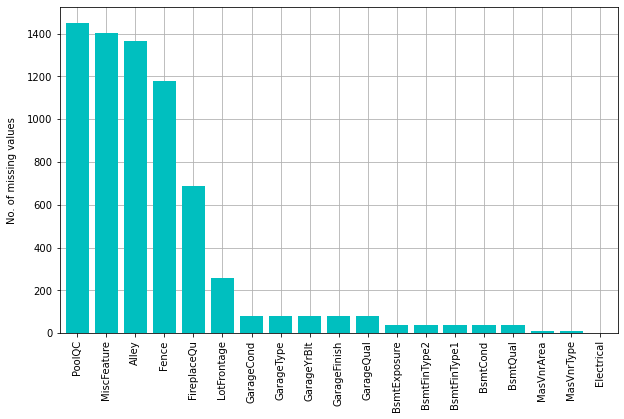

In [8]:
nans = df_train.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color='c')
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

In [9]:
cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
df_train[cols] = df_train[cols].fillna("None")
df_test[cols] = df_test[cols].fillna("None")

cols = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
df_train[cols] = df_train[cols].fillna(0)
df_test[cols] = df_test[cols].fillna(0)

cols = ["MasVnrType", "MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual", "Functional"]
df_train[cols] = df_train.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))
df_test[cols] = df_test.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

cols = ["GarageArea", "LotFrontage"]
df_train[cols] = df_train.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.median()))
df_test[cols] = df_test.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.median()))



In [10]:
cols = df_train.columns[df_train.isna().any() & (df_train.dtypes==np.number)]
for col in cols:
    df_train[col].fillna(0, inplace=True)
    
cols = df_train.columns[df_train.isna().any() & (df_train.dtypes!=np.number)]
for col in cols:
    df_train[col].fillna('Others', inplace=True)
    
cols = df_test.columns[df_test.isna().any() & (df_test.dtypes==np.number)]
for col in cols:
    df_test[col].fillna(0, inplace=True)
    
cols = df_test.columns[df_test.isna().any() & (df_test.dtypes!=np.number)]
for col in cols:
    df_test[col].fillna('Others', inplace=True)

In [11]:
df_train.isna().sum().sum()

0

In [12]:
df_train["TotalSF"] = df_train["GrLivArea"] + df_train["TotalBsmtSF"]
df_train["TotalPorchSF"] = df_train["OpenPorchSF"] + df_train["EnclosedPorch"] + df_train["3SsnPorch"] + df_train["ScreenPorch"]
df_train["TotalBath"] = df_train["FullBath"] + df_train["BsmtFullBath"] + 0.5 * (df_train["BsmtHalfBath"] + df_train["HalfBath"])

df_test["TotalSF"] = df_test["GrLivArea"] + df_test["TotalBsmtSF"]
df_test["TotalPorchSF"] = df_test["OpenPorchSF"] + df_test["EnclosedPorch"] + df_test["3SsnPorch"] + df_test["ScreenPorch"]
df_test["TotalBath"] = df_test["FullBath"] + df_test["BsmtFullBath"] + 0.5 * (df_test["BsmtHalfBath"] + df_test["HalfBath"])

In [13]:
cols = ["MSSubClass", "YrSold"]
df_train[cols] = df_train[cols].astype(str)
df_test[cols] = df_test[cols].astype(str)

In [14]:
df_train["SinMoSold"] = np.sin(2 * np.pi * df_train["MoSold"] / 12)
df_train["CosMoSold"] = np.cos(2 * np.pi * df_train["MoSold"] / 12)
df_train = df_train.drop("MoSold", axis=1)

df_test["SinMoSold"] = np.sin(2 * np.pi * df_test["MoSold"] / 12)
df_test["CosMoSold"] = np.cos(2 * np.pi * df_test["MoSold"] / 12)
df_test = df_test.drop("MoSold", axis=1)

In [15]:
df_train.isna().sum().sum()

0

In [16]:
skew = df_train.skew(numeric_only=True).abs()
cols = skew.index
for col in cols:
    df_train.loc[:, col] = np.where(df_train[col]<0, -1*np.power(-df_train[col], 1/3), np.power(df_train[col], 1/3) ) 
    df_test.loc[:, col] = np.where(df_test[col]<0, -1*np.power(-df_test[col], 1/3), np.power(df_test[col], 1/3) ) 
#    df_train.loc[:, col] = -np.tanh(df_train[col]**1/5)**3
#    df_test.loc[:, col] = -np.tanh(df_test[col]**1/5)**3
    
    

In [17]:
df_train.isna().sum().sum()

0

In [18]:
cols = df_train.select_dtypes(np.number).columns
df_train[cols] = RobustScaler().fit_transform(df_train[cols])
df_test[cols] = RobustScaler().fit_transform(df_test[cols])

In [19]:
df_train.isna().sum().sum()

0

In [20]:
features_encoded = df_train.columns[df_train.dtypes!=np.number].to_list()
#features_encoded

In [21]:
for col in features_encoded:
    unique_values = df_train[col].astype(str).unique()
    unique_values = np.append(unique_values, 'Others')
    column_names = [col+'_'+v_val for v_val in unique_values]
    ohe = OneHotEncoder(sparse=False, dtype=int)
    df_test.loc[~df_test[col].astype(str).isin(unique_values), col] = 'Others'
    ohe.fit(unique_values.reshape(-1, 1))
    
    df_col = pd.DataFrame(ohe.transform(df_train[col].astype(str).values.reshape(-1, 1)), columns=column_names)
    df_train.drop(col, axis=1, inplace=True)
    df_train = pd.concat([df_train, df_col], axis=1)
    
    df_col = pd.DataFrame(ohe.transform(df_test[col].values.astype(str).reshape(-1, 1)), columns=column_names)
    df_test.drop(col, axis=1, inplace=True)
    df_test = pd.concat([df_test, df_col], axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
df_train.fillna(0, axis=1, inplace=True)

In [23]:
df_train[df_train.columns[df_train.isna().any()]].isna().sum()

Series([], dtype: float64)

In [24]:
X = df_train
y = np.log1p(df_train_orig['SalePrice'])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=207)

<IPython.core.display.Javascript object>

In [26]:
reg = LinearRegression()
rf = RandomForestRegressor(n_estimators=300,       # No of trees in forest
                             criterion = "mse",       # Can also be mae
                             max_features = "sqrt",  # no of features to consider for the best split
                             max_depth= 10,    #  maximum depth of the tree
                             min_samples_split= 2,   # minimum number of samples required to split an internal node
                             min_impurity_decrease=0, # Split node if impurity decreases greater than this value.
                             oob_score = True,       # whether to use out-of-bag samples to estimate error on unseen data.
                             n_jobs = -1,            #  No of jobs to run in parallel
                             random_state=0,
                             verbose = 0            # Controls verbosity of process
                             )

<IPython.core.display.Javascript object>

In [27]:
reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt',
                      min_impurity_decrease=0, n_estimators=300, n_jobs=-1,
                      oob_score=True, random_state=0)

In [28]:
rf.oob_score_

0.8685186257524402

In [29]:
y_pred=rf.predict(X_test)
squared = np.square(y_pred - y_test)
rf_error = np.sqrt(np.sum(squared)/len(y_test))
rf_error

0.1478128961489032

0.112296213620829

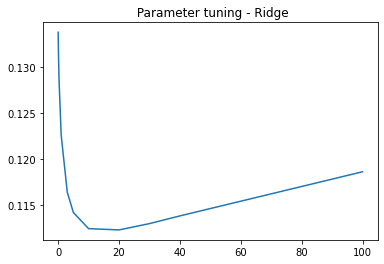

In [30]:
from sklearn.linear_model import Ridge
def rmse_ridge(ridge_model):
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_test)
    squared = np.square(y_pred-y_test)
    ridge_error = np.sqrt(np.sum(squared)/len(y_test))
    return(ridge_error)

alphas = [0.01, 0.02, 0.1, 0.3, 1, 3, 5, 10, 20, 30,40,100]
cv_ridge = [rmse_ridge(Ridge(alpha = alpha )).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " Parameter tuning - Ridge")
#plt.xlabel("alpha")
#plt.ylabel("rmse")
cv_ridge.min()

In [31]:
dict(tuple(zip(cv_ridge.values, cv_ridge.index)))

{0.13379567331420958: 0.01,
 0.13354295796605076: 0.02,
 0.1317326484954244: 0.1,
 0.1285811937340771: 0.3,
 0.12259931553186766: 1.0,
 0.11640334291383465: 3.0,
 0.11419216129561695: 5.0,
 0.11243659740883363: 10.0,
 0.112296213620829: 20.0,
 0.11298216764612197: 30.0,
 0.11381930740362249: 40.0,
 0.11861968370587912: 100.0}

In [32]:
ridge_model = Ridge(alpha = 20.0 )
ridge_model.fit(X_train, y_train)
result = ridge_model.predict(df_test)
result = np.round(np.expm1(result), 0).astype(int)
result_df = pd.DataFrame(result, columns=['SalePrice'])
final_result_df = pd.concat([df_test_orig[['Id']], result_df], axis=1)
final_result_df.to_csv('D:/Study/Python/Projects/house_prices_advanced_regression_techniques/predicted_SalePrices.csv', index=False)

In [33]:
rmse_ridge(reg)

0.13368303183536343